In [408]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import numpy as np
import pandas as pd

from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components#n_components, labels = connected_components(csgraph=graph, directed=False, return_labels=True)

import io
import pickle
import zipfile

###########
# import our libraries
from blue_conduit_spatial.utilities import *
from blue_conduit_spatial.evaluation import *
from blue_conduit_spatial.distance_matrix import *

LAT_MIN, LAT_MAX = 42.97, 43.09
LON_MIN, LON_MAX = -83.75, -83.62

########### set random state
np.random.seed(297)

In [36]:
# load train and test data
Xtrain, Xtest, Ytrain, Ytest = load_datasets('../data/processed')

# clean train and test data (only eliminating the homes with missing LAT/LON)
bad_train_indices = (Xtrain[Xtrain['Latitude']==-1.0]).index.values
bad_test_indices = (Xtest[Xtest['Latitude']==-1.0]).index.values
Xtrain = Xtrain.drop(bad_train_indices)
Xtest = Xtest.drop(bad_test_indices)
Ytrain = Ytrain.drop(bad_train_indices)
Ytest = Ytest.drop(bad_test_indices)

for arr, name in zip([Xtrain, Xtest, Ytrain, Ytest], ['Xtrain', 'Xtest', 'Ytrain', 'Ytest']):
    print(name, arr.shape)

Xtrain (20082, 303)
Xtest (6775, 303)
Ytrain (20082, 4)
Ytest (6775, 4)


In [100]:
# load jared model predictions
jared_train_pred = pd.read_csv('../data/processed/predictions/jared_train_yhat.csv').values
jared_test_pred = pd.read_csv('../data/processed/predictions/jared_test_yhat.csv').values

# use reverse of the bad indices above to eliminate the homes with missing LAT/LON
good_train_indices = np.array([i for i in range(jared_train_pred.shape[0]) if i not in bad_train_indices])
good_test_indices = np.array([i for i in range(jared_test_pred.shape[0]) if i not in bad_test_indices])
Ytrain_pred_xgboost = jared_train_pred[good_train_indices,:]
Ytest_pred_xgboost = jared_test_pred[good_test_indices,:]
print('XGBoost YTrain pred', Ytrain_pred_xgboost.shape)
print('XGBoost YTest pred', Ytest_pred_xgboost.shape)

XGBoost YTrain pred (20082, 2)
XGBoost YTest pred (6775, 2)


In [356]:
# load distance data
dis_path = '../data/road_distances.npz'
distances = np.load(dis_path, allow_pickle=True)
graph = distances['road_distances']
graph[graph==(1.00e+05)]=0.0 #assign invalid 1e5 values to be 0
    
train_indices, test_indices, train_graph, test_graph = load_train_test_dist_matrices()
idx_to_train_idx = lambda idx : np.where(train_indices==idx)[0][0]
idx_to_test_idx = lambda idx : np.where(test_indices==idx)[0][0]

print('graph', graph.shape)
print('graph train', train_graph.shape)
print('graph test', test_graph.shape)


graph (26857, 26857)
graph train (20082, 20082)
graph test (6775, 6775)


In [494]:
# build subgraph, tracking train/test split
n_subgraph = 200
np.random.seed(538)
subgraph_indices = np.random.choice(np.arange(graph.shape[0]),n_subgraph)
subgraph = graph[subgraph_indices,:][:,subgraph_indices]

def get_lat_lon(i):
    if i in train_indices:
        return np.array([Xtrain.Latitude.values[idx_to_train_idx(i)], Xtrain.Longitude.values[idx_to_train_idx(i)]])
    elif i in test_indices:
        return np.array([Xtest.Latitude.values[idx_to_test_idx(i)], Xtest.Longitude.values[idx_to_test_idx(i)]])


print('subgraph', subgraph.shape)
print(subgraph)

subgraph (200, 200)
[[ 0.   0.   0.  ...  0.   0.   0. ]
 [ 0.   0.   0.  ...  0.  92.8  0. ]
 [ 0.   0.   0.  ...  0.   0.   0. ]
 ...
 [ 0.   0.   0.  ...  0.   0.   0. ]
 [ 0.  89.5  0.  ...  0.   0.   0. ]
 [ 0.   0.   0.  ...  0.   0.   0. ]]


In [563]:
def plot_graph(fig, ax, color_vals, title, labels = {}):
    
    #g = nx.from_scipy_sparse_matrix(csr_matrix(subgraph))
    g = nx.from_numpy_array(subgraph)
    
    # draw nodes with colors
    graph_pos = {i : get_lat_lon(idx) for i, idx in enumerate(subgraph_indices)}
    nx.draw_networkx_nodes(g, graph_pos, node_color=color_vals, vmin=0,vmax=1,cmap = cm.RdYlGn_r, ax=ax)
    
    # grab edge weights
    all_weights = []
    for (_,_,data) in g.edges(data=True):
        all_weights.append(data['weight'])
    unique_weights = list(set(all_weights))
    
    # draw weights one at a time. Is this working?
    for weight in unique_weights:
        weighted_edges = np.array([(node1,node2) for (node1,node2,edge_attr) in g.edges(data=True) if edge_attr['weight']==weight])
        width = weight*n_subgraph/sum(all_weights)
        nx.draw_networkx_edges(g,graph_pos,edgelist=weighted_edges,width=width,ax=ax)

    # add color scale
    cb = fig.colorbar(cm.ScalarMappable(norm=Normalize(), cmap=cm.RdYlGn_r), ax=ax)
    cb.set_label('LEAD value')
    
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_xlim(LAT_MIN, LAT_MAX)
    ax.set_ylim(LON_MIN, LON_MAX)
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    limits=ax.axis('on')

In [584]:
# number of nearest neighbors
K = 5

def get_LEAD_value(idx):
    # If train, then 1: lead, 0: no lead. If test, then return baseline xgboost probability
    if idx in train_indices:
        return Ytrain.dangerous.values[idx_to_train_idx(idx)]
    elif idx in test_indices:
        return Ytest_pred_xgboost[idx_to_test_idx(idx),1]  

def diffusion_distance_weights(distances):
    return 1/(1 + distances)

def subgraph_neighbors():
    # get nearest neighbors for each node of the subgraph
    
    nn = NearestNeighbors(n_neighbors=K, metric='precomputed')
    neighbors_subgraph = subgraph.copy()
    neighbors_subgraph[neighbors_subgraph==0] = 1e7 # nearest neighbor algorithm processes the zeros as nearest neighbors, so replace them with a large value
    nn.fit(neighbors_subgraph)
    distances, indices = nn.kneighbors()
    
    # UPDATE THIS FUNCTION ABOVE TO CHANGE HOW THE DISTANCE INFLUENCES THE WEIGHT
    weights = diffusion_distance_weights(distances)
    return indices, distances, weights

def diffusion_step(LEAD, verbose=False):
    
    neighbor_idx, neighbor_dis, neighbor_weights = subgraph_neighbors()
    outputs = np.average(LEAD[neighbor_idx], axis=1, weights = neighbor_weights)
    if verbose:
        
        # show neighbor influence
        for i, idx in enumerate(subgraph_indices):
            print('Node', i)
            print('\told LEAD value', get_LEAD_value(idx))
            neighbor_lead = LEAD[neighbor_idx[i,:]]
            for k in range(K):
                print(f'\t Neighbor {neighbor_idx[i,k]} : dist {neighbor_dis[i,k]}, weight {np.round(neighbor_weights[i,k],3)}, LEAD value {np.round(neighbor_lead[k],3)}')
            print('\t new LEAD value:', outputs[i])
        
        # show overall probability shifts
        print('pre-diff LEAD values --> post-diff LEAD values')
        for p1, p2 in zip(LEAD, outputs):
            print(f'{np.round(p1,2)} --> {np.round(p2,2)}')
        
    return outputs


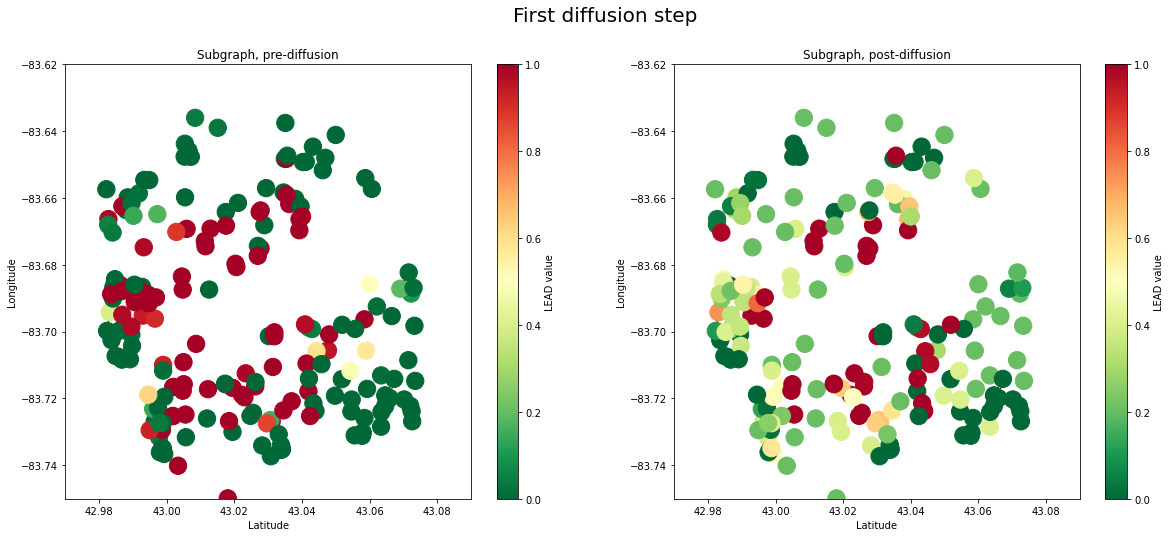

In [589]:
def diffusion():
    
    subgraph_LEAD_values = np.array([get_LEAD_value(idx) for idx in subgraph_indices])

    # UPDATE THIS FUNCTION ABOVE TO CHANGE HOW WE INCORPORATE NEIGHBOR PROBABILITIES
    # for now, only do one step
    diffusion_outputs = diffusion_step(subgraph_LEAD_values, verbose=False)
    
    # plot subgraph pre and post diffusion
    fig, ax = plt.subplots(1, 2, figsize=(20,8))
    plt.suptitle('First diffusion step', fontsize=20)
    plot_graph(fig, ax[0], subgraph_LEAD_values, 'Subgraph, pre-diffusion')
    plot_graph(fig, ax[1], diffusion_outputs, 'Subgraph, post-diffusion')
    plt.show()
        
diffusion()
